In [5]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.19.0


In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("cashbowman/ai-generated-images-vs-real-images")

print("Path to dataset files:", path)

100%|██████████| 476M/476M [00:03<00:00, 131MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/cashbowman/ai-generated-images-vs-real-images/versions/1


In [2]:
path

'/root/.cache/kagglehub/datasets/cashbowman/ai-generated-images-vs-real-images/versions/1'

In [8]:
for root, dirs, files in os.walk(path):
    print("Root:", root)
    print("Dirs:", dirs)
    print("Files:", len(files))
    break

Root: /root/.cache/kagglehub/datasets/cashbowman/ai-generated-images-vs-real-images/versions/1
Dirs: ['RealArt', 'AiArtData']
Files: 0


In [9]:
import os, shutil

base_path = path
subfolders = ['RealArt', 'AiArtData']
for folder in subfolders:
    inner_path = os.path.join(base_path, folder, folder)
    outer_path = os.path.join(base_path, folder)

    if os.path.exists(inner_path):
        for file_name in os.listdir(inner_path):
            src = os.path.join(inner_path, file_name)
            dst = os.path.join(outer_path, file_name)
            shutil.move(src, dst)
        shutil.rmtree(inner_path)
        print(f"✅ Flattened: {inner_path}")
    else:
        print(f"⚠️ No nested folder found in: {folder}")


✅ Flattened: /root/.cache/kagglehub/datasets/cashbowman/ai-generated-images-vs-real-images/versions/1/RealArt/RealArt
✅ Flattened: /root/.cache/kagglehub/datasets/cashbowman/ai-generated-images-vs-real-images/versions/1/AiArtData/AiArtData


In [11]:
import os

dataset_path = "/root/.cache/kagglehub/datasets/cashbowman/ai-generated-images-vs-real-images/versions/1"

for folder in ["AiArtData", "RealArt"]:
    folder_path = os.path.join(dataset_path, folder)
    files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    print(f"📁 {folder}: {len(files)} images")


📁 AiArtData: 536 images
📁 RealArt: 434 images


In [12]:
import matplotlib.pyplot as plt
import random
from PIL import Image

ai_folder = os.path.join(dataset_path, "AiArtData")
real_folder = os.path.join(dataset_path, "RealArt")

ai_samples = random.sample(os.listdir(ai_folder), 3)
real_samples = random.sample(os.listdir(real_folder), 3)



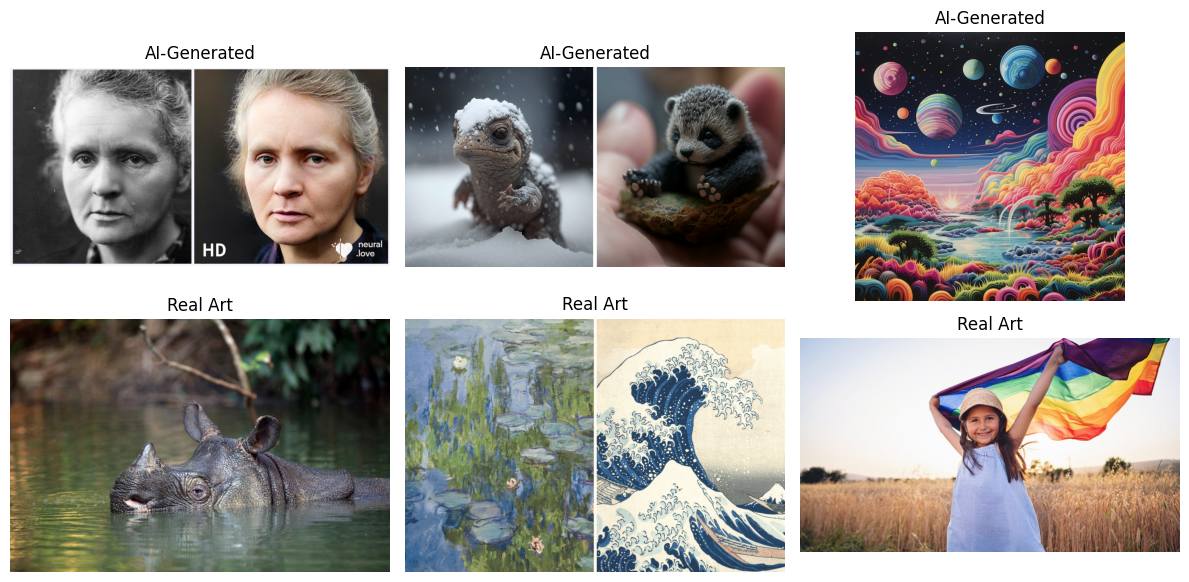

In [13]:
plt.figure(figsize=(12, 6))


for i, img_name in enumerate(ai_samples):
    img = Image.open(os.path.join(ai_folder, img_name))
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title("AI-Generated")
    plt.axis("off")

for i, img_name in enumerate(real_samples):
    img = Image.open(os.path.join(real_folder, img_name))
    plt.subplot(2, 3, i+4)
    plt.imshow(img)
    plt.title("Real Art")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [58]:
IMG_SIZE = (244, 244)  # MesoNet recommended input
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
EPOCHS = 20

In [59]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Create validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 971 files belonging to 2 classes.
Using 777 files for training.
Found 971 files belonging to 2 classes.
Using 194 files for validation.


In [62]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomBrightness(0.1)
])

In [63]:
normalization_layer = layers.Rescaling(1./255)

In [64]:
train_ds = (
    train_ds
    .map(lambda x, y: (normalization_layer(data_augmentation(x)), y), num_parallel_calls=AUTOTUNE)
    .cache()
    .shuffle(1000)
    .prefetch(buffer_size=AUTOTUNE)
)

val_ds = (
    val_ds
    .map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

In [65]:
from tensorflow.keras import models
from tensorflow.keras.optimizers import Adam



def MesoNet(input_shape=(224, 224, 3)):
    model = models.Sequential([
        layers.Conv2D(8, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(8, (5, 5), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(16, (5, 5), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(16, (5, 5), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(4, 4)),

        layers.GlobalAveragePooling2D(),  # ✅ replaces Flatten
        layers.Dropout(0.5),
        layers.Dense(16, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # binary classification
    ])
    return model




In [66]:
model = MesoNet()


In [67]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])



In [68]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 224, 224, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 224, 224, 8)    │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 112, 112, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 112, 112, 8)    │         1,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 112, 112, 8)    │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 56, 56, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 56, 56, 16)     │         3,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 56, 56, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 28, 28, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 28, 28, 16)     │         6,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 28, 28, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 16)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,945 (46.66 KB)

 Trainable params: 11,849 (46.29 KB)

 Non-trainable params: 96 (384.00 B)

In [69]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.4811 - loss: 0.8374 - val_accuracy: 0.4794 - val_loss: 0.6951
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.5931 - loss: 0.6730 - val_accuracy: 0.4794 - val_loss: 0.6956
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.5938 - loss: 0.6692 - val_accuracy: 0.4433 - val_loss: 0.7024
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.6197 - loss: 0.6586 - val_accuracy: 0.4485 - val_loss: 0.7038
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.6237 - loss: 0.6447 - val_accuracy: 0.4485 - val_loss: 0.7123
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.6696 - loss: 0.6032 - val_accuracy: 0.4485 - val_loss: 0.7250
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.6133 - loss: 0.6586 - val_accuracy: 0.4485 - val_loss: 0.7243
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.6138 - loss: 0.6384 - val_accuracy: 0.4485 - val_loss:

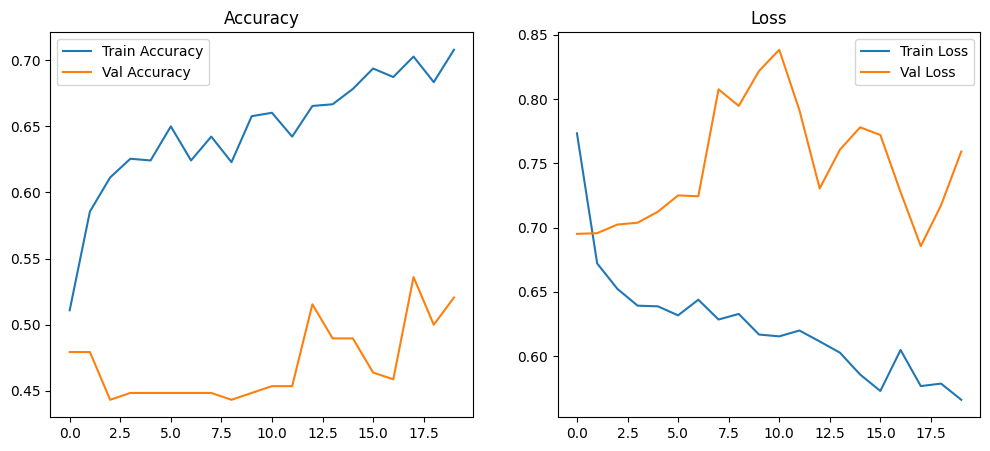

In [70]:


plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Accuracy")
plt.legend()


plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.legend()

plt.show()


In [74]:
val_loss, val_acc = model.evaluate(val_ds)
print(f" Validation Accuracy: {val_acc*100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 417ms/step - accuracy: 0.5108 - loss: 0.7769
 Validation Accuracy: 52.06%
Validation Loss: 0.7591


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


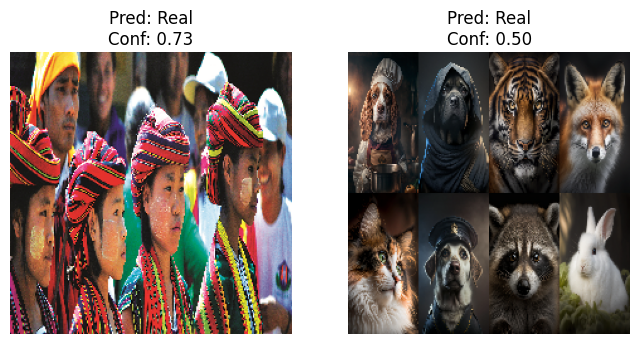

In [87]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import os
import random

# Get all image paths from both folders
all_images = []
for folder in ["AiArtData", "RealArt"]:
    folder_path = os.path.join(dataset_path, folder)
    for img_file in os.listdir(folder_path):
        if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
            all_images.append(os.path.join(folder_path, img_file))

# Randomly select 2 images from the whole dataset
sample_images = random.sample(all_images, 2)

plt.figure(figsize=(8,4))

for i, img_path in enumerate(sample_images):
    img = image.load_img(img_path, target_size=(224,224))  # keep consistent with model input
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    pred = model.predict(img_array)[0][0]
    pred_label = "AI-Generated" if pred >= 0.5 else "Real"
    confidence = pred if pred >= 0.5 else 1 - pred

    plt.subplot(1,2,i+1)
    plt.imshow(img)
    plt.title(f"Pred: {pred_label}\nConf: {confidence:.2f}")
    plt.axis("off")

plt.show()


In [82]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np


y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_pred_prob = model.predict(val_ds)
y_pred = (y_pred_prob >= 0.5).astype(int)

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=["Real", "AI-Generated"]))

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 350ms/step
Classification Report:

              precision    recall  f1-score   support

        Real       0.79      0.18      0.29       107
AI-Generated       0.48      0.94      0.64        87

    accuracy                           0.52       194
   macro avg       0.64      0.56      0.46       194
weighted avg       0.65      0.52      0.45       194

Confusion Matrix:
 [[19 88]
 [ 5 82]]


In [94]:
model.save("image_model.keras")


In [96]:
model.save("/image_model.h5")
